In [ ]:
# 1회 이상 실행시 오류가 발생합니다.
! mkdir -p /home/faith/workspace/cifar/generated_samples
! mkdir -p /home/faith/workspace/cifar/training_checkpoints
! mkdir -p /home/faith/workspace/cifar/training_history

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from IPython import display

In [13]:
checkpoint_dir = '/home/faith/workspace/cifar/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
                                 

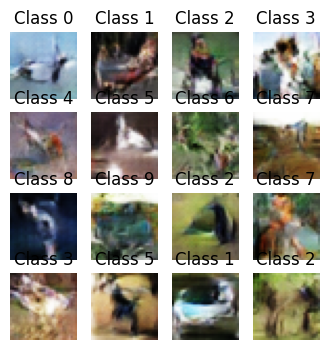

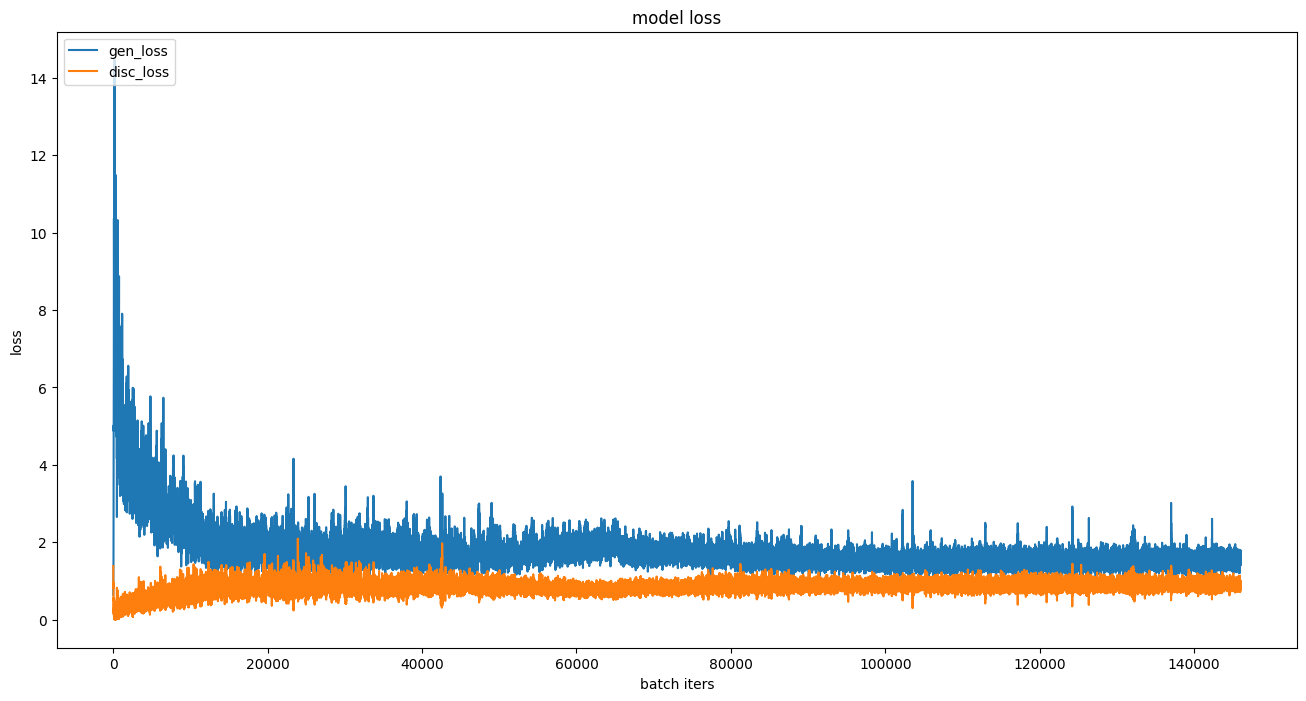

Time for epoch 745 is 21.032670497894287 sec
Epoch 746 | iter 1 | Gen Loss: 1.6267 | Disc Loss: 0.8547
Epoch 746 | iter 51 | Gen Loss: 1.3919 | Disc Loss: 0.9341
Epoch 746 | iter 101 | Gen Loss: 1.4100 | Disc Loss: 0.9984


KeyboardInterrupt: 

In [12]:


# CIFAR-10 데이터셋 로드
cifar10 = tf.keras.datasets.cifar10
(train_x, train_y), (test_x, test_y) = cifar10.load_data()

# 데이터 전처리
train_x = train_x.astype('float32')
train_x = (train_x - 127.5) / 127.5

BUFFER_SIZE = 50000
BATCH_SIZE = 256

# 데이터셋 준비
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

def make_generator_model():
    noise_input = layers.Input(shape=(100,))
    label_input = layers.Input(shape=(10,))
    
    x = layers.Concatenate()([noise_input, label_input])
    x = layers.Dense(8*8*512, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Reshape((8, 8, 512))(x)
    
    x = layers.Conv2DTranspose(256, (4, 4), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

    model = tf.keras.Model([noise_input, label_input], x)
    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=[32, 32, 13]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1))

    return model

generator = make_generator_model()
discriminator = make_discriminator_model()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# train_step 
@tf.function
def train_step(images, labels):
    batch_size = tf.shape(images)[0]
    noise = tf.random.normal([batch_size, 100])
    
    one_hot_labels = tf.one_hot(tf.squeeze(labels), depth=10)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, one_hot_labels], training=True)

        label_channels = tf.repeat(tf.expand_dims(one_hot_labels, axis=1), repeats=32, axis=1)
        label_channels = tf.repeat(tf.expand_dims(label_channels, axis=2), repeats=32, axis=2)
        
        real_input = tf.concat([images, label_channels], axis=3)
        fake_input = tf.concat([generated_images, label_channels], axis=3)

        real_output = discriminator(real_input, training=True)
        fake_output = discriminator(fake_input, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def generate_and_save_images(model, epoch, it, test_input, test_labels):
    predictions = model([test_input, test_labels], training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :] + 1) / 2.0)
        plt.axis('off')
        plt.title(f'Class {tf.argmax(test_labels[i])}')
    
    plt.savefig('/home/faith/workspace/cifar/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
    plt.show()


def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.figure(figsize=(16,8))
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # # summarize history for accuracy  
    # plt.subplot(212)  
    # plt.plot(history['fake_accuracy'])  
    # plt.plot(history['real_accuracy'])  
    # plt.title('discriminator accuracy')  
    # plt.ylabel('accuracy')  
    # plt.xlabel('batch iters')  
    # plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/home/faith/workspace/cifar/training_history/train_history_{:04d}.png'
                    .format(epoch))
    plt.show()

# train
def train(dataset, epochs):
    history = {'gen_loss':[], 'disc_loss':[]}
    
    num_examples_to_generate = 16
    test_noise = tf.random.normal([num_examples_to_generate, 100])
    test_labels = tf.range(0, 10, delta=1)
    test_labels = tf.concat([test_labels, tf.random.uniform([6], minval=0, maxval=10, dtype=tf.int32)], axis=0)
    test_labels = tf.one_hot(test_labels, depth=10)

    for epoch in range(epochs):
        start = time.time()

        for it, (image_batch, label_batch) in enumerate(dataset):
            gen_loss, disc_loss = train_step(image_batch, label_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)

            if it % 50 == 0:
                print('Epoch {} | iter {} | Gen Loss: {:.4f} | Disc Loss: {:.4f}'.format(epoch+1, it+1, gen_loss, disc_loss))
        
        # 에포크마다 이미지 생성
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, 0, test_noise, test_labels)
        draw_train_history(history, epoch)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # 마지막 에포크 후 이미지 생성
    generate_and_save_images(generator, epochs, 0, test_noise, test_labels)
    
    return history

EPOCHS = 1000
history = train(train_dataset, EPOCHS)

# 학습 결과 시각화
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss")
plt.plot(history['gen_loss'], label="Generator")
plt.plot(history['disc_loss'], label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/home/faith/workspace/cifar/training_history/loss_plot.png')
plt.show()

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.


# 특정 클래스의 이미지 생성
def generate_specific_class(class_num):
    noise = tf.random.normal([1, 100])
    one_hot_label = tf.one_hot([class_num], depth=10)
    generated_image = generator([noise, one_hot_label], training=False)
    
    plt.figure(figsize=(4, 4))
    plt.imshow((generated_image[0, :, :, :] + 1) / 2.0)
    plt.axis('off')
    plt.title(f'Generated image for class {class_num}')
    plt.savefig(f'/home/faith/workspace/cifar/generated_samples/class_{class_num}.png')
    plt.show()

# 각 클래스별 이미지 생성
for i in range(10):
    generate_specific_class(i)

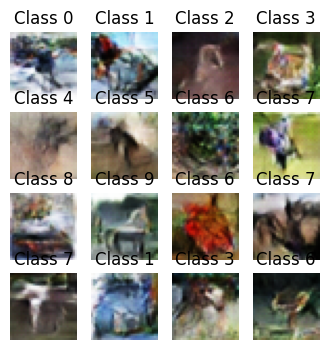

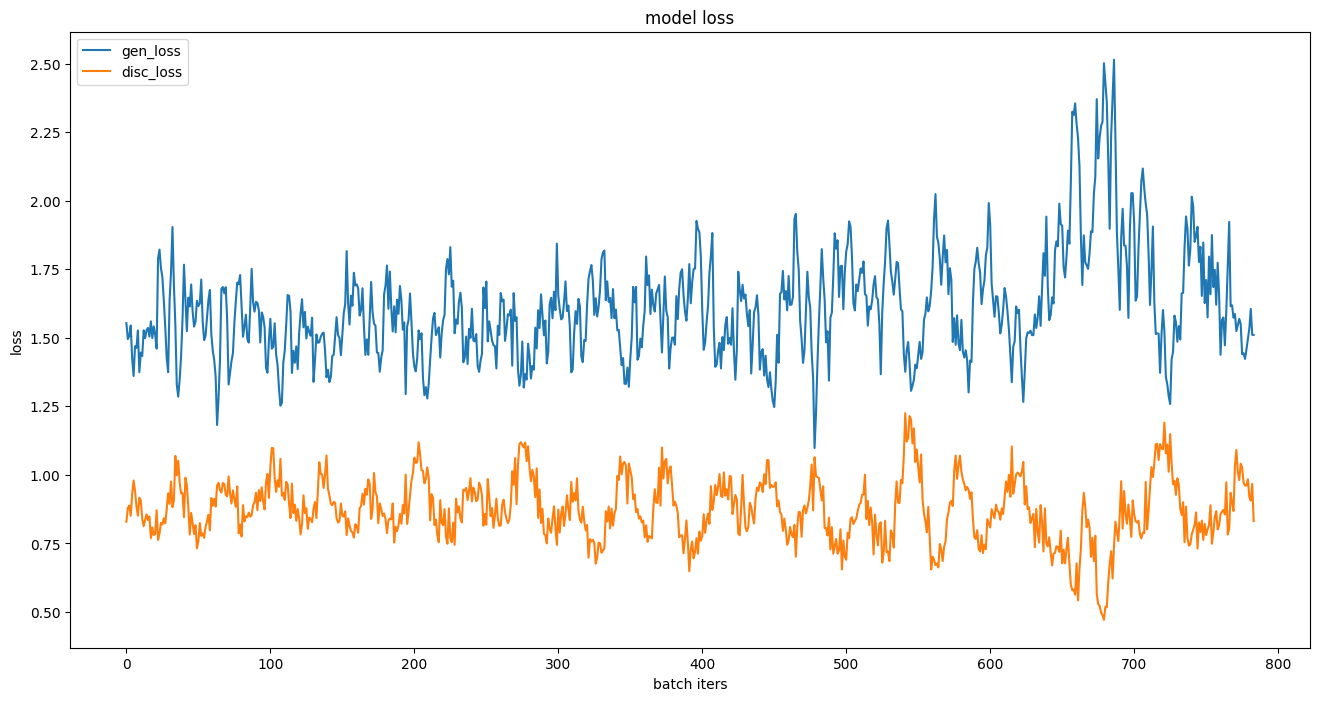

Time for epoch 4 is 18.51155114173889 sec
Epoch 5 | iter 1 | Gen Loss: 1.5061 | Disc Loss: 0.9067
Epoch 5 | iter 51 | Gen Loss: 1.4666 | Disc Loss: 0.8461


In [16]:
# train
def train(dataset, epochs, save_every):
    history = {'gen_loss':[], 'disc_loss':[]}
    
    num_examples_to_generate = 16
    test_noise = tf.random.normal([num_examples_to_generate, 100])
    test_labels = tf.range(0, 10, delta=1)
    test_labels = tf.concat([test_labels, tf.random.uniform([6], minval=0, maxval=10, dtype=tf.int32)], axis=0)
    test_labels = tf.one_hot(test_labels, depth=10)

    for epoch in range(epochs):
        start = time.time()

        for it, (image_batch, label_batch) in enumerate(dataset):
            gen_loss, disc_loss = train_step(image_batch, label_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)

            if it % 50 == 0:
                print('Epoch {} | iter {} | Gen Loss: {:.4f} | Disc Loss: {:.4f}'.format(epoch+1, it+1, gen_loss, disc_loss))
            if (epoch + 1) % save_every == 0:
                checkpoint.save(file_prefix=checkpoint_prefix)
        
        # 에포크마다 이미지 생성
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, 0, test_noise, test_labels)
        draw_train_history(history, epoch)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # 마지막 에포크 후 이미지 생성
    generate_and_save_images(generator, epochs, 0, test_noise, test_labels)
    
    return history

save_every = 5
EPOCHS = 10
history = train(train_dataset, EPOCHS, save_every)